In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM, MORCGPRegressor2, MORCGP
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 6,    
    'lines.markersize': 7  
})

In [2]:
def apply_overlap(y_train, overlap_ratio):
    N, D = y_train.shape
    indices = np.arange(N)

    n_overlap = int(overlap_ratio * N)

    shared_indices = np.random.choice(indices, size=n_overlap, replace=False)

    y_obs = np.full_like(y_train, np.nan)

    y_obs[shared_indices, :] = y_train[shared_indices, :]

    remaining_indices = np.setdiff1d(indices, shared_indices)

    n_unique_per_output = (N - n_overlap) // D

    for d in range(D):
        if d < D - 1:
            chosen = np.random.choice(remaining_indices, size=n_unique_per_output, replace=False)
            remaining_indices = np.setdiff1d(remaining_indices, chosen)
        else:
            chosen = remaining_indices
        y_obs[chosen, d] = y_train[chosen, d]

    return y_obs

## MOGP

[[1.       0.9     ]
 [0.9      1.000096]]


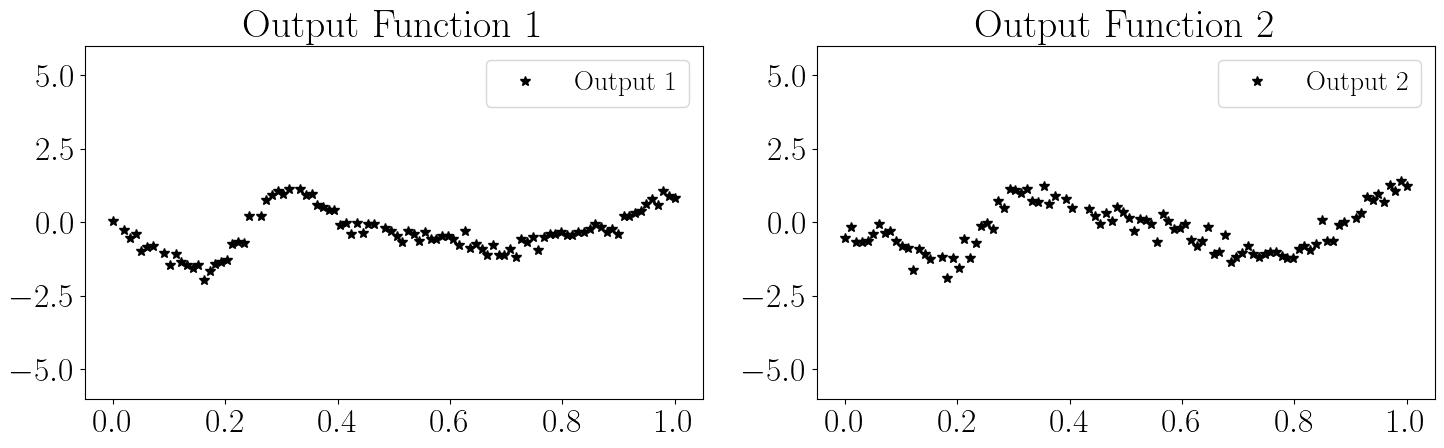

In [3]:
np.random.seed(42)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

A = np.array([[1, 0], 
              [0.9, 0.436]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.09])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

# indices_025 = np.where((x_train >= 0.20) & (x_train <= 0.30))[0]
# outlier_indices_025 = np.random.choice(indices_025, 1, replace=False)
# y_train[outlier_indices_025, 0] = -5

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

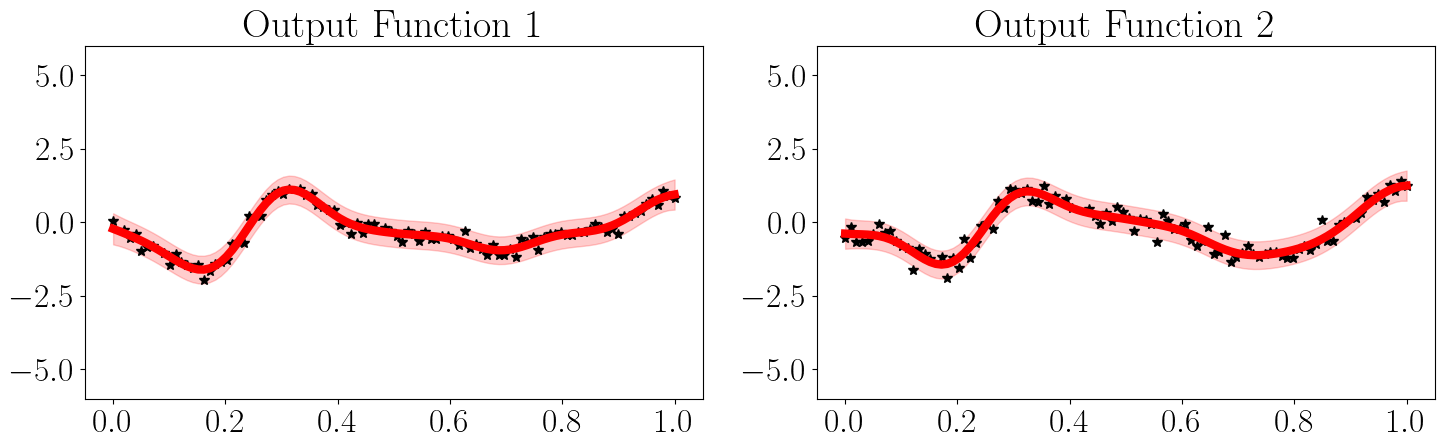

In [4]:
# mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

## Original IMQ - MORCGP

In [ ]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9
epsilons = np.array([0.05, 0])

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(epsilons[0] * n_points), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
morcgp = MORCGPRegressor_PM(mean = 0, length_scale=0.1, noise = noise, A=A, epsilons=epsilons)
# morcgp = MORCGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

## MORCGP - cross channel predictive

[[1.999396 1.200486]
 [1.200486 1.000642]]


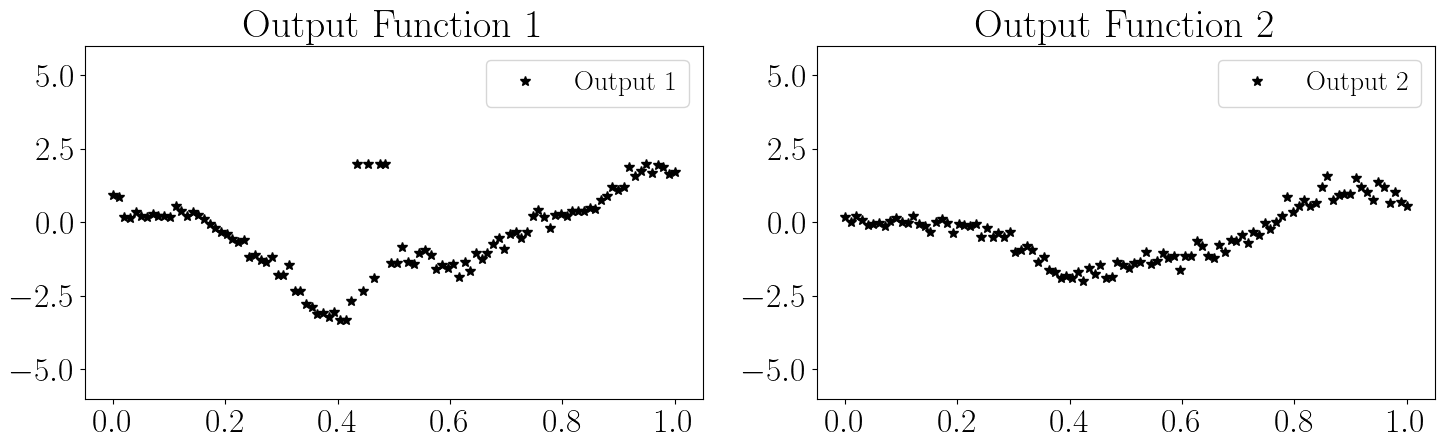

In [2]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

# y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [3]:
# Instantiate and train
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_B = mogp.B
optim_noise = mogp.noise

[[1.79217658 1.06770288]
 [1.06770288 0.78326255]]
-187.19776979611316
-187.19777133941378
-187.19776891010093
-187.19776958466602
-187.19776943806878
-187.19776973072516
-187.19776957934093
-187.197769769948
-97.82615876184677
-97.8261592711047
-97.82615842490829
-97.82615885671339
-97.826158773758
-97.82615876819014
-97.82615866893664
-97.82615869952261
-73.75564661786106
-73.75564695728703
-73.75564653714122
-73.75564677471431
-73.75564657746818
-73.75564665076125
-73.75564664037093
-73.75564658119869
-43.23137856883105
-43.23137855405258
-43.23137880446944
-43.23137875910562
-43.231378578568524
-43.23137852768315
-43.23137855590175
-43.231378626426526
-34.366980792503064
-34.36698067355329
-34.366980995810366
-34.36698087416947
-34.36698081532075
-34.36698073834049
-34.366980780571396
-34.36698086685745
-31.454830180629738
-31.45483018651435
-31.4548301763251
-31.454830102066428
-31.45482985406268
-31.45483097052159
-31.454830585721588
-31.45482923913329
-30.780986497915556
-30.780

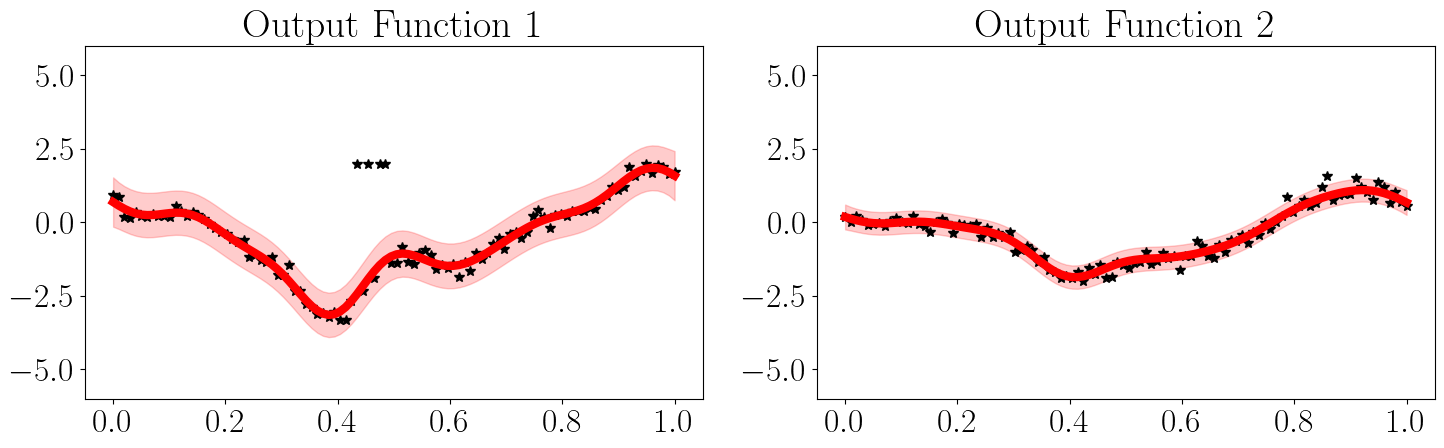

In [11]:
mcd = MinCovDet(support_fraction=0.9).fit(y_train)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6, 1e-6])
print(robust_covariance)

# test_cov = optim_B + np.diag(optim_noise)

# # ORIGINAL MORCGP
# original_morcgp = MORCGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
# predictive_mean, predictive_variances = original_morcgp.fit(x_train, y_train)
# original_morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, B_weighted=optim_B, noise_weighted=optim_noise)

# x_test = np.linspace(0, 1, 100).reshape(-1, 1)
# original_mu, original_var = original_morcgp.predict(x_test)
# original_std = np.sqrt(original_var + original_morcgp.noise)



# NEW MORCGP
morcgp = MORCGP(mean = 0, length_scale=1, noise_var = np.array([0.1, 0.1]), A=A)
initial_gamma, initial_c = morcgp.fit(x_train, y_train)
gammas, cs = morcgp.optimize_loo_cv(print_opt_param = True, print_iter_objective=True, k=1, init_cov=robust_covariance, fix_weights=True)

x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise_var)


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    # axs[i].plot(x_test.flatten(), original_mu[:, i], 'orange', label=f'Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), original_mu[:, i] - 2*original_std[:, i], original_mu[:, i] + 2*original_std[:, i], color='orange', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

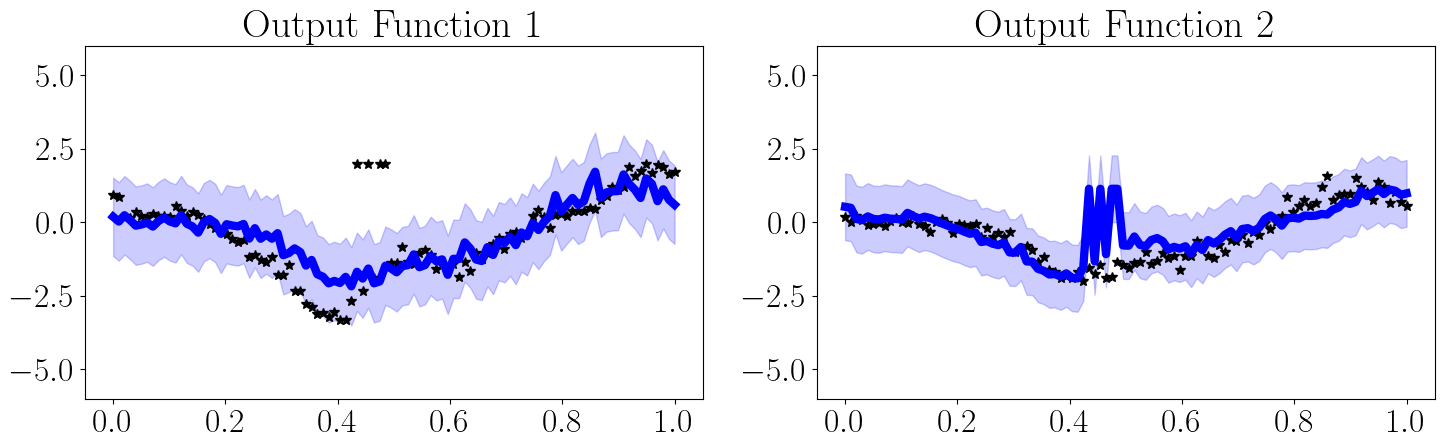

In [ ]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), ((morcgp.weights_01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    # axs[i].plot(x_train.flatten(), gammas[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), gammas[:, i] - np.sqrt(cs[:, i]), gammas[:, i] + np.sqrt(cs[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_train.flatten(), initial_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_test.flatten(), initial_gamma[:, i] - np.sqrt(initial_c[:, i]), initial_gamma[:, i] + np.sqrt(initial_c[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    # axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    # axs[i].plot(x_test.flatten(), original_mu[:, i], 'orange', label=f'Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), original_mu[:, i] - 2*original_std[:, i], original_mu[:, i] + 2*original_std[:, i], color='orange', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

## Fixed weights

In [ ]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# noise = np.array([0.01, 0.16])
noise = np.array([0.04, 0.04])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_length_scale = mogp.length_scale
optim_A = mogp.A
optim_B = mogp.B
optim_noise = mogp.noise

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=A)
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train, B_weighted=optim_B, noise_weighted=optim_noise)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

In [ ]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), ((morcgp.w01.reshape(2,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

## Plot

[[1.999396 1.200486]
 [1.200486 1.000642]]


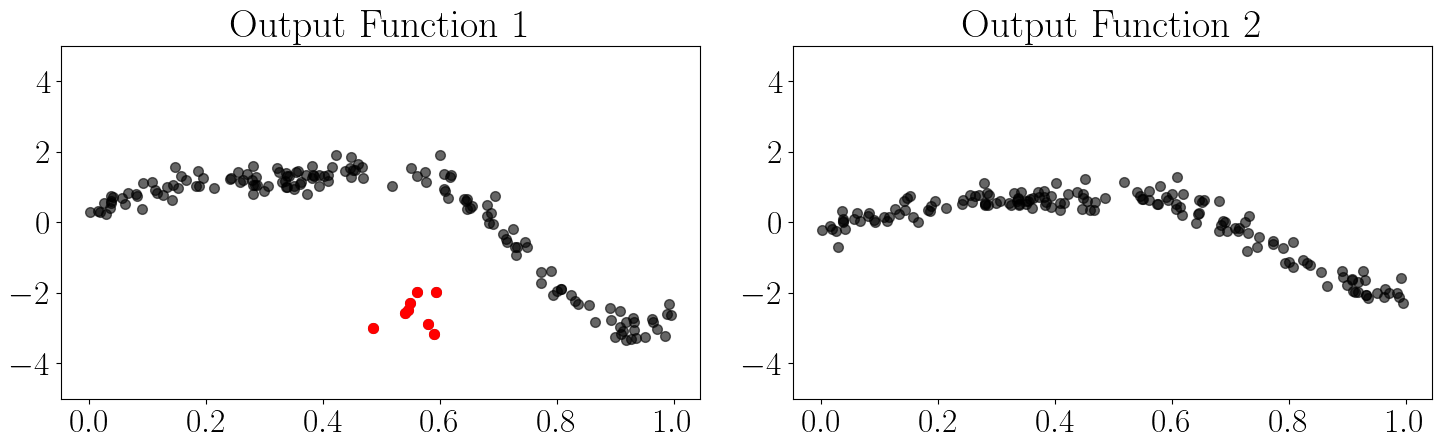

In [ ]:
np.random.seed(48)
# Initialisation
epsilon = 0.05
constant_mean = 0
length_scale = 0.2
variance = 1
n_outputs = 2
n_points = 160
overlap_ratio = 1

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

noise1 = 0.05
noise2 = 0.05
noise = np.array([noise1, noise2])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.sort(np.random.uniform(0, 1, n_points)).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

outlier_range = np.where((x_train >= 0.48) & (x_train <= 0.6))[0]
outlier_indices = np.random.choice(outlier_range, int(epsilon*n_points), replace=False)
y_train[outlier_indices, 0] = np.random.normal(loc=-3, scale=0.5, size=outlier_indices.shape[0])

mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

y_train -= np.mean(y_train, axis=0)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-5, 5])
    # axs[i].legend()

plt.tight_layout()
plt.show()

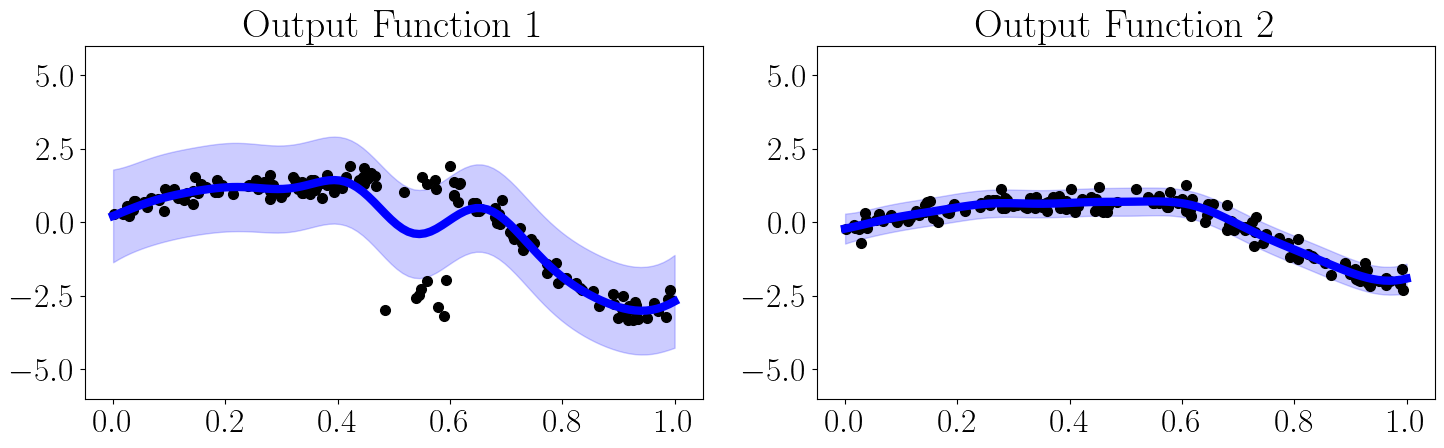

In [23]:
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
# mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_length_scale = mogp.length_scale
optim_B = mogp.B
optim_A = mogp.A
optim_noise = mogp.noise

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='blue', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

[[2.39324319 1.32661524]
 [1.32661524 0.80821717]]


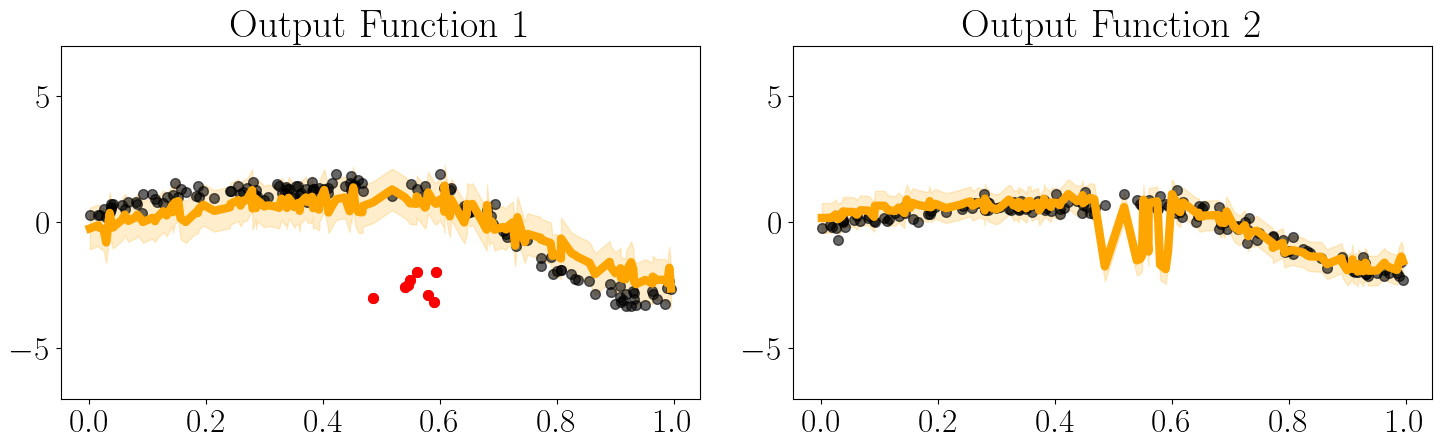

In [25]:
# morcgp = MORCGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=optim_A)
# predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

mcd = MinCovDet(support_fraction=0.95).fit(y_train)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6, 1e-6])
print(robust_covariance)

morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=length_scale, noise = noise, A=A)
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(x_train, y_train, B_weighted=B, noise_weighted=noise)

# # Optimize hyperparameters
# predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, update_weights=True)
                                                               
# morcgp = MORCGPRegressor(mean=0, length_scale=length_scale, noise = noise, A=A)
# morcgp.fit(x_train, y_train)
# predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, B_weighted=B, noise_weighted=noise)


# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

length_scale_morcgp = morcgp.length_scale
A_morcgp = morcgp.A


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')

    # Initial pred mean and var
    axs[i].plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='orange', label=f'Predictive Mean')
    axs[i].fill_between(x_train.flatten(), initial_predictive_mean[:, i] - np.sqrt(initial_predictive_variances[:, i]), initial_predictive_mean[:, i] + np.sqrt(initial_predictive_variances[:, i]), color='orange', alpha=0.2, label=f'±2 Std. Dev.')

    # # Pred mean and var
    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_train.flatten(), predictive_mean[:, i] - 2 * np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + 2 * np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    # # Predictions
    # axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='green', label=f'Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-7, 7])

plt.tight_layout()
plt.show()

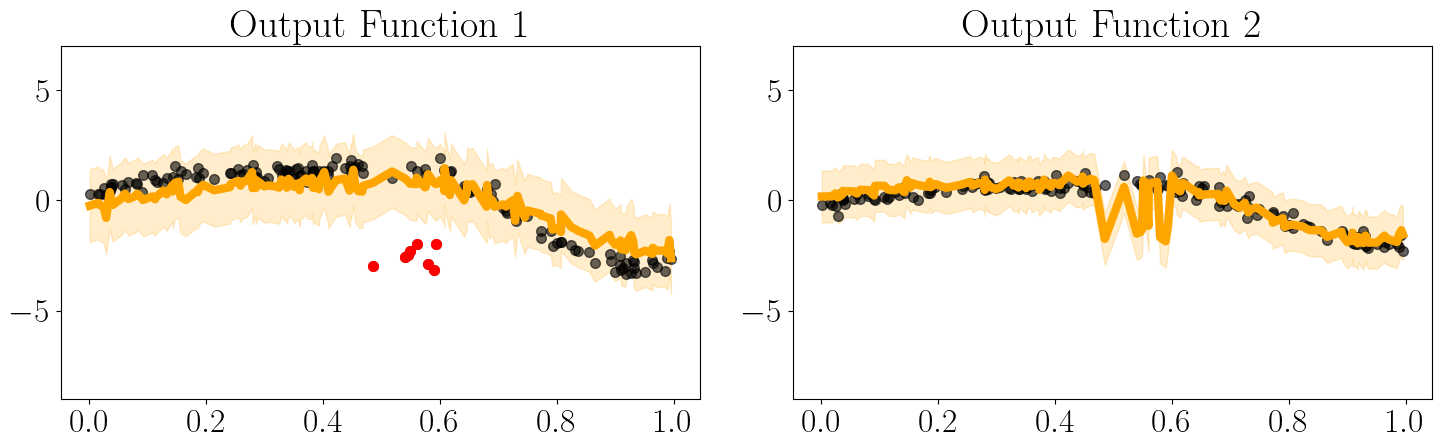

In [21]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')

    # Initial pred mean and var
    axs[i].plot(x_train.flatten(), initial_predictive_mean[:, i], '-', color='orange', label=f'Predictive Mean')
    axs[i].fill_between(x_train.flatten(), initial_predictive_mean[:, i] - 2 * np.sqrt(initial_predictive_variances[:, i]), initial_predictive_mean[:, i] + 2 * np.sqrt(initial_predictive_variances[:, i]), color='orange', alpha=0.2, label=f'±2 Std. Dev.')

    # # Pred mean and var
    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_train.flatten(), predictive_mean[:, i] - 2 * np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + 2 * np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    # # Predictions
    # axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='green', label=f'Predicted Mean')
    # axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-9, 7])

plt.tight_layout()
plt.show()

In [7]:
print(morcgp.w01)

[[0.80768099]
 [0.86293926]
 [0.81838422]
 [0.66769769]
 [0.60083681]
 [0.99501836]
 [0.73229557]
 [0.76562794]
 [0.81652392]
 [0.61211974]
 [0.75072586]
 [0.94157795]
 [0.67292771]
 [0.75324328]
 [0.82676974]
 [0.91939992]
 [0.532694  ]
 [0.58539148]
 [0.62693291]
 [0.72156151]
 [0.87827946]
 [0.67612641]
 [0.99943727]
 [0.70122484]
 [0.63386595]
 [0.9460981 ]
 [0.51407142]
 [0.51170155]
 [0.71212397]
 [0.53175972]
 [0.79007577]
 [0.73961504]
 [0.77875619]
 [0.70783201]
 [0.75671427]
 [0.73705616]
 [0.79029523]
 [0.84774839]
 [0.76646732]
 [0.99546344]
 [0.77013336]
 [0.92742494]
 [0.55143413]
 [0.95032089]
 [0.66658022]
 [0.93322866]
 [0.91075736]
 [0.85508054]
 [0.57684253]
 [0.60262377]
 [0.91376347]
 [0.78070782]
 [0.91677751]
 [0.70281073]
 [0.82715575]
 [0.6551391 ]
 [0.84333221]
 [0.8538223 ]
 [0.85935954]
 [0.65439034]
 [0.67686823]
 [0.71630036]
 [0.83733513]
 [0.84070341]
 [0.99082386]
 [0.78877307]
 [0.70630131]
 [0.64361294]
 [0.68446562]
 [0.76396937]
 [0.75899411]
 [0.96

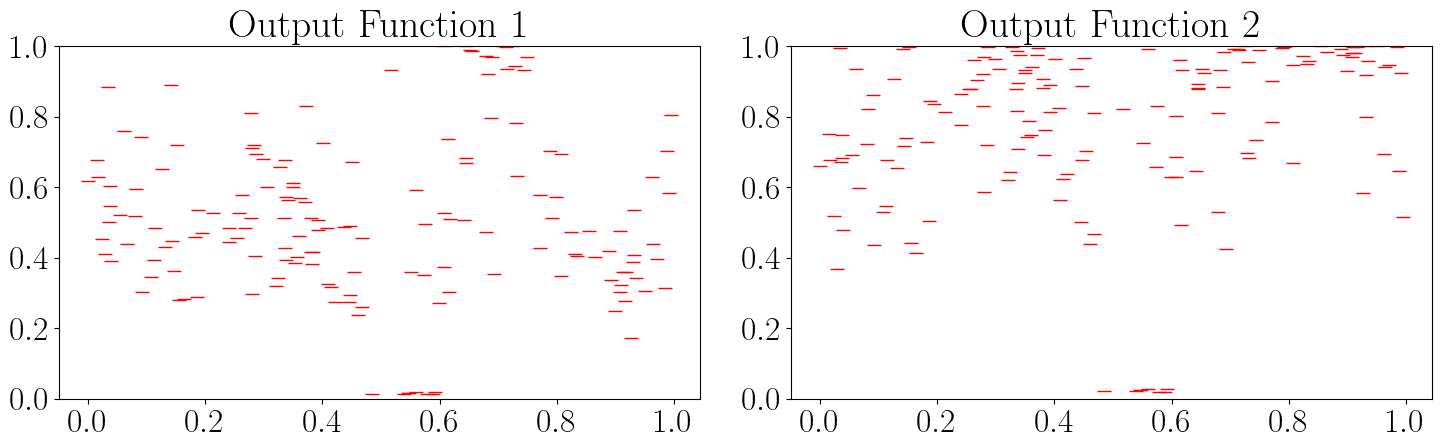

In [15]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):

    axs[i].plot(x_train.flatten(), ((morcgp.w01.reshape(n_outputs,-1).T)**2)[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()

Optimized length_scale: 0.0663, noise: 0.488150, rbf_variance: 0.7593


KeyboardInterrupt: 

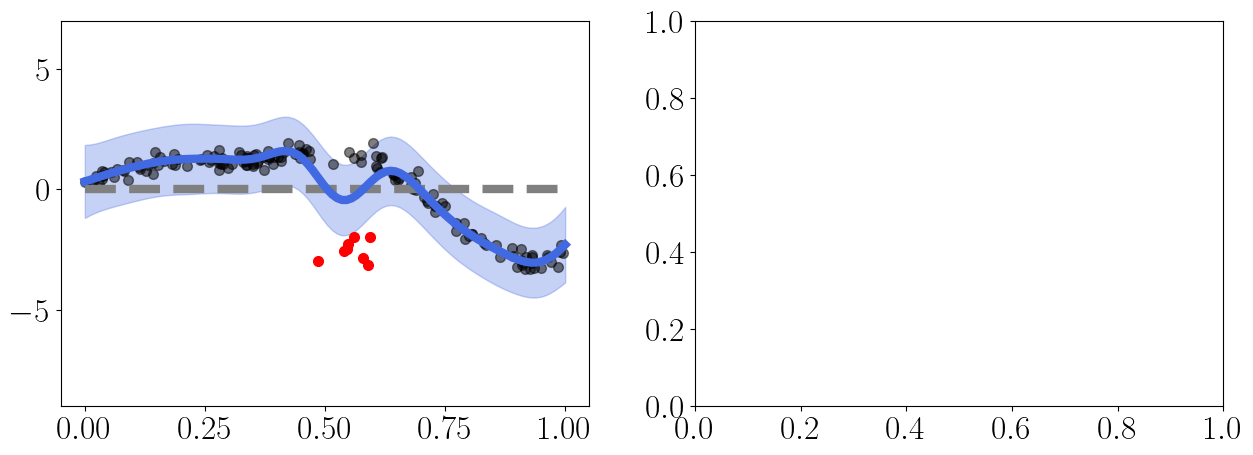

In [16]:
y_train1, y_train2 = y_train[:, 0].reshape(-1,1), y_train[:, 1].reshape(-1,1)

mu_rcgp = np.full((len(x_test), 2), np.nan)
std_rcgp = np.full((len(x_test), 2), np.nan)

# Plot 1 ------------------

constant_mean = ConstantMean(constant=0)
rcgp1 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=noise1, epsilon=epsilon)
rcgp1.fit(x_train, y_train1)
rcgp1.optimize_loo_cv(weighted=False, print_opt_param=True)

mu_rcgp[:, 0], var_rcgp = rcgp1.predict(x_test)
std_rcgp[:, 0] = np.sqrt(var_rcgp + rcgp1.noise)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(x_train[mask], y_train1[mask], 'o', color='black', alpha=0.5)
axs[0].plot(x_train[~mask], y_train1[~mask], 'o', color='red')
axs[0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0].plot(x_test, mu_rcgp[:, 0].ravel(), color="royalblue")
axs[0].fill_between(x_test.ravel(), mu_rcgp[:, 0].ravel() - 1.96 * std_rcgp[:, 0], mu_rcgp[:, 0].ravel() + 1.96 * std_rcgp[:, 0], alpha=0.3, color='royalblue')
axs[0].set_ylim([-9, 7])

# Plot 2 ------------------

rcgp2 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=noise2, epsilon=epsilon)
rcgp2.fit(x_train, y_train2)
rcgp2.optimize_loo_cv(weighted=False, print_opt_param=True)

mu_rcgp[:, 1], var2 = rcgp2.predict(x_test)
std_rcgp[:, 1] = np.sqrt(var2 + rcgp2.noise)

axs[1].plot(x_train[mask], y_train2[mask], 'o', color='black', alpha=0.5)
# axs[1].plot(x_train[~mask], y_train2[~mask], 'o', color='red')
axs[1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1].plot(x_test, mu_rcgp[:, 1].ravel(), color="royalblue")
axs[1].fill_between(x_test.ravel(), mu_rcgp[:, 1].ravel() - 1.96 * std_rcgp[:, 1], mu_rcgp[:, 1].ravel() + 1.96 * std_rcgp[:, 1], alpha=0.3, color='royalblue')
axs[1].set_ylim([-9, 7])


In [ ]:
morcgp = MORCGPRegressor_PM(mean = 0, length_scale=optim_length_scale, noise = noise, A=optim_A, epsilons=np.array([epsilon, 0]))
morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )


# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_pm, var_pm = morcgp.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')

    axs[i].plot(x_test.flatten(), mu_pm[:, i], '-', color='green', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_morcgp[:, i] + 2*std_pm[:, i], color='green', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-9, 7])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

# Plot 1
constant_mean = ConstantMean(constant=0)
rcgp1 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=0.04, epsilon=epsilon)
rcgp1.fit(x_train, y_train[:, 0].reshape(-1,1))
rcgp1.optimize_loo_cv(weighted=False, print_opt_param=False)

mu1, var1 = rcgp1.predict(x_test)
std1 = np.sqrt(var1 + rcgp1.noise)

axs[0, 0].plot(x_train[mask], y_train[mask, 0], 'o', color='black', alpha=0.5)
axs[0, 0].plot(x_train[~mask], y_train[~mask, 0], 'o', color='red')
axs[0, 0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0, 0].plot(x_test, mu1.ravel(), color="green")
axs[0, 0].fill_between(x_test.ravel(), mu1.ravel() - 1.96 * std1, mu1.ravel() + 1.96 * std1, alpha=0.3, color='green')
axs[0, 0].set_title('$y_1$', fontsize=24, pad=10)

# Plot 2
rcgp2 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=0.04, epsilon=epsilon)
rcgp2.fit(x_train, y_train[:, 1].reshape(-1,1))
rcgp2.optimize_loo_cv(weighted=False, print_opt_param=False)

mu2, var2 = rcgp2.predict(x_test)
std2 = np.sqrt(var2 + rcgp2.noise)

axs[0, 1].plot(x_train[mask], y_train[mask, 1], 'o', color='black', alpha=0.5)
# axs[0, 1].plot(x_train[~mask], y_train[~mask, 1], 'o', color='red')
axs[0, 1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[0, 1].plot(x_test, mu2.ravel(), color="green", label='RCGP')
axs[0, 1].fill_between(x_test.ravel(), mu2.ravel() - 1.96 * std2, mu2.ravel() + 1.96 * std2, alpha=0.3, color='green')
axs[0, 1].set_title('$y_2$', fontsize=24, pad=10)
# axs[0, 1].legend()

# Plot 3
axs[1, 0].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1, 0].plot(x_train.flatten(), y_train[:, 0], 'o', color='black', alpha=0.6)
axs[1, 0].plot(x_train.flatten()[~mask], y_train[:, 0][~mask], 'o', color='red')
axs[1, 0].plot(x_test.flatten(), mu_morcgp[:, 0], '-', color='royalblue', label='MORCGP')
axs[1, 0].fill_between(x_test.flatten(), mu_morcgp[:, 0] - 2*std_morcgp[:, 0], mu_morcgp[:, 0] + 2*std_morcgp[:, 0], color='royalblue', alpha=0.2)

# Plot 4
axs[1, 1].plot(x_test, n_points * np.zeros((len(x_test), 1)), '--', color='grey')
axs[1, 1].plot(x_train.flatten(), y_train[:, 1], 'o', color='black', alpha=0.6)
axs[1, 1].plot(x_test.flatten(), mu_morcgp[:, 1], '-', color='royalblue', label='MORCGP')
axs[1, 1].fill_between(x_test.flatten(), mu_morcgp[:, 1] - 2*std_morcgp[:, 1], mu_morcgp[:, 1] + 2*std_morcgp[:, 1], color='royalblue', alpha=0.2)
# axs[1, 1].legend()

for ax in axs.flat:
    ax.set_ylim([-5, 5])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlim([0, 1])
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

for i in range(2):
    axs[i, 0].set_yticks([-4, 0, 4])          
    axs[i, 1].set_yticks([-4, 0, 4])          
    axs[i, 1].set_yticklabels([])            

# for ax in axs[:, 0]:
#     ax.set_ylabel('$y_1$', fontsize=24, rotation=0, labelpad=10, va='center', ha='right')

# for ax in axs[:, 1]:
#     ax.set_ylabel('$y_2$', fontsize=24, rotation=0, labelpad=25, va='center', ha='left')

for ax in axs[0, :]:
    ax.set_xticklabels([])


import matplotlib.lines as mlines

prior_mean_line = mlines.Line2D([], [], color='grey', linestyle='--', label='Prior mean')
rcgp_line = mlines.Line2D([], [], color='green', linestyle='-', label='RCGP')
morcgp_line = mlines.Line2D([], [], color='royalblue', linestyle='-', label='MORCGP')

fig.legend(handles=[prior_mean_line, rcgp_line, morcgp_line],
           loc='lower center', bbox_to_anchor=(0.5, -0.02),
           ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.show()

# fig.savefig("./results/synthetic_MOGP_MORCGP.pdf", format='pdf', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))

# Plot 1

for i, ax in enumerate(axes[:2, 0]):
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4, label=f'Output {i+1}')
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outlier points')

    ax.plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MORCGP')
    ax.fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='royalblue', alpha=0.2)

    ax.set_ylim([-9, 5])
    ax.set_xlim([0, 1])

# Plot 2
for i, ax in enumerate(axes[:2, 1]):
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4, label=f'Output {i+1}')
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outlier points')

    ax.plot(x_test.flatten(), mu_pm[:, i], '-', color='green', label='RCGP')
    ax.fill_between(x_test.flatten(), mu_pm[:, i] - 2*std_pm[:, i], mu_pm[:, i] + 2*std_pm[:, i], color='green', alpha=0.2)

    ax.set_ylim([-9, 5])
    ax.set_xlim([0, 1])

# Plot 3
for i, ax in enumerate(axes[:2, 2]):
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4, label=f'Output {i+1}')
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outlier points')

    ax.plot(x_test.flatten(), mu_mogp[:, i], '-', color='orange', label='MOGP')
    ax.fill_between(x_test.flatten(), mu_mogp[:, i] - 2*std_mogp[:, i], mu_mogp[:, i] + 2*std_mogp[:, i], color='orange', alpha=0.2)

    ax.set_ylim([-9, 5])
    ax.set_xlim([0, 1])

# Plot 4
for i, ax in enumerate(axes[:2, 3]):
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4, label=f'Output {i+1}')
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outlier points')

    ax.plot(x_test.flatten(), mu_rcgp[:, i], '-', color='teal', label='RCGP')
    ax.fill_between(x_test.flatten(), mu_rcgp[:, i] - 2*std_rcgp[:, i], mu_rcgp[:, i] + 2*std_rcgp[:, i], color='teal', alpha=0.2)

    ax.set_ylim([-9, 5])
    ax.set_xlim([0, 1])

for row in range(2):
    for col in range(1, 4):
        axes[row, col].set_yticklabels([])

for row in range(2):
    axes[row, 0].yaxis.set_tick_params(labelleft=True)
    for ax in axes[0, :]:
        ax.set_xticklabels([])
    for ax in axes[1, :]:
        ax.xaxis.set_tick_params(labelbottom=True)

for row in range(2):
    for col in range(4):
        axes[row, col].set_xticks([0, 0.5])

        for row in range(2):
            for col in range(4):
                for spine in axes[row, col].spines.values():
                    spine.set_linewidth(2)

                    axes[0, 0].set_ylabel('$y_1$', fontsize=18, labelpad=10, rotation=0)
                    axes[1, 0].set_ylabel('$y_2$', fontsize=18, labelpad=10, rotation=0)
        
        titles = [r"MORCGP ($w_{\scriptscriptstyle\textrm{MORCGP}}$)", r"MORCGP ($w_{\scriptscriptstyle\textrm{RCGP}}$)", "MOGP", "RCGP"]
        for col, title in enumerate(titles):
            axes[0, col].set_title(title, fontsize=18, pad=12)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.tight_layout()
plt.show()

## Plot 2

[[1.999396 1.249976]
 [1.249976 1.00048 ]]


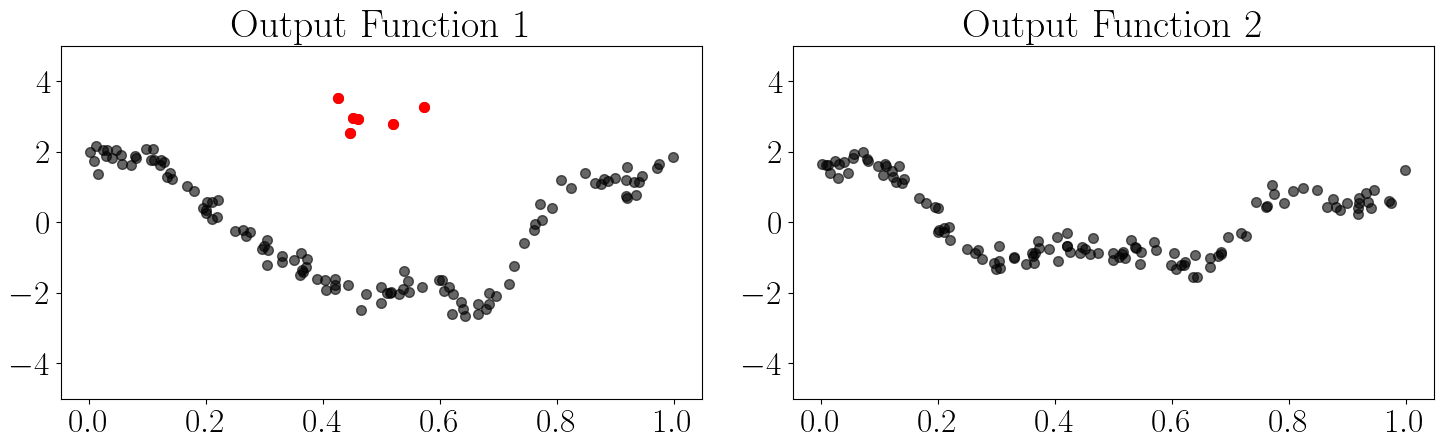

In [58]:
np.random.seed(15)
# print(i)
# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 120
overlap_ratio = 1
epsilon = 0.05

A = np.array([[1.414, 0], 
    [0.884, 0.468]])
B = A @ A.T
print(B)

D = B.shape[0]

noise1 = 0.05
noise2 = 0.05
noise = np.array([noise1, noise2])
if noise.shape[0] == 1:
    noise_matrix = noise * np.eye(D)
else:
    noise_matrix = np.diag(noise)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.sort(np.random.uniform(0, 1, n_points)).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_matrix, np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

# y_train = apply_overlap(y_train, overlap_ratio)

outlier_range = np.where((x_train >= 0.42) & (x_train <= 0.58))[0]
outlier_indices = np.random.choice(outlier_range, int(epsilon*n_points), replace=False)
y_train[outlier_indices, 0] = np.random.normal(loc=2.5, scale=0.5, size=outlier_indices.shape[0])

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

y_train -= np.mean(y_train, axis=0)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-5, 5])
    # axs[i].legend()

plt.tight_layout()
plt.show()

In [16]:
# MOGP
mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
# mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
optim_length_scale = mogp.length_scale
optim_B = mogp.B
optim_A = mogp.A
optim_noise = mogp.noise

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

# MORCGP
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train, B_weighted=optim_B, noise_weighted=optim_noise)

# print(morcgp.loo_cv(length_scale=length_scale, noise=np.array([0.05, 0.05]), A=A, weighted=True))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

# RCGP
y_train1, y_train2 = y_train[:, 0].reshape(-1,1), y_train[:, 1].reshape(-1,1)

mu_rcgp = np.full((len(x_test), 2), np.nan)
std_rcgp = np.full((len(x_test), 2), np.nan)

constant_mean = ConstantMean(constant=0)
rcgp1 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=noise1, epsilon=epsilon)
rcgp1.fit(x_train, y_train1)
rcgp1.optimize_loo_cv(weighted=False, print_opt_param=False)

mu_rcgp[:, 0], var_rcgp = rcgp1.predict(x_test)
std_rcgp[:, 0] = np.sqrt(var_rcgp + rcgp1.noise)

rcgp2 = RCGPRegressor(mean=constant_mean, length_scale=0.2, rbf_variance=2, noise=noise2, epsilon=epsilon)
rcgp2.fit(x_train, y_train2)
rcgp2.optimize_loo_cv(weighted=False, print_opt_param=False)

mu_rcgp[:, 1], var2 = rcgp2.predict(x_test)
std_rcgp[:, 1] = np.sqrt(var2 + rcgp2.noise)

# MORCGP
morcgp = MORCGPRegressor_PM(mean = 0, length_scale=optim_length_scale, noise = noise, A=optim_A, epsilons=np.array([epsilon, 0]))
morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )


# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_pm, var_pm = morcgp.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp.noise)

In [59]:
# MOGP
mogp = MOGPRegressor(mean = 0, length_scale=length_scale, noise = noise, A=A)
# mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
# mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
# optim_length_scale = mogp.length_scale
# optim_B = mogp.B
# optim_A = mogp.A
# optim_noise = mogp.noise

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

In [37]:
mcd = MinCovDet(support_fraction=0.9).fit(y_train)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6, 1e-6])
print(robust_covariance)

# MORCGP
morcgp = MORCGPRegressor_fixed_weights(mean = 0, length_scale=length_scale, noise = noise, A=A)
# morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_length_scale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train, B_weighted=B, noise_weighted=noise)

# print(morcgp.loo_cv(length_scale=length_scale, noise=np.array([0.05, 0.05]), A=A, weighted=True))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

[[2.40193128 1.44556864]
 [1.44556864 1.07516282]]


KeyboardInterrupt: 

In [60]:
mcd = MinCovDet(support_fraction=0.9).fit(y_train)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6, 1e-6])
print(robust_covariance)

morcgp = MORCGP(mean=0, length_scale=length_scale, noise_var=noise, A=A)
morcgp.fit(x_train, y_train, epsilons=np.array([epsilon, 0]))
# morcgp.optimize_loo_cv(print_opt_param=True, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)

x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

[[2.41167199 1.44938335]
 [1.44938335 1.07593291]]


In [27]:
print(gamma.shape)

(120, 2)


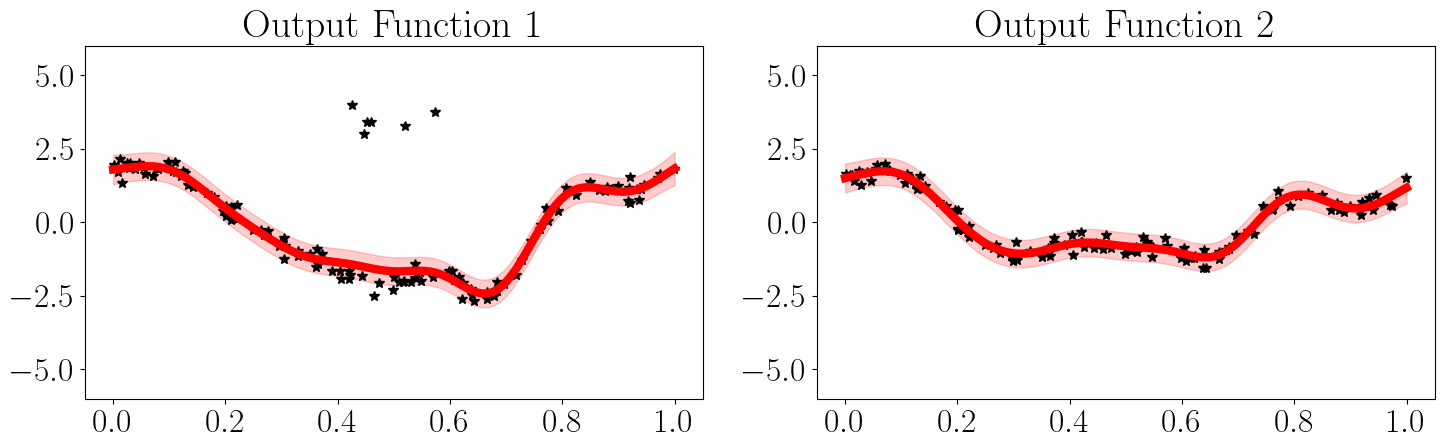

In [49]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), ((morcgp.weights_01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    # axs[i].plot(x_train.flatten(), gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_train.flatten(), gamma[:, i] - np.sqrt(c[:, i]), gamma[:, i] + np.sqrt(c[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    # axs[i].plot(x_train.flatten(), init_gamma[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_train.flatten(), init_gamma[:, i] - np.sqrt(init_c[:, i]), init_gamma[:, i] + np.sqrt(init_c[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2*std_morcgp[:, i], mu_morcgp[:, i] + 2*std_morcgp[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

In [27]:
mcd = MinCovDet(support_fraction=0.9).fit(y_train)
robust_covariance = mcd.covariance_
empty_noise = np.array([1e-6, 1e-6])
print(robust_covariance)

# MORCGP
morcgp = MORCGPRegressor2(mean = 0, length_scale=length_scale, noise = noise, A=A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train, B_weighted=robust_covariance, noise_weighted=empty_noise)

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, 
                    #    B_weighted=optim_B, noise_weighted=optim_noise
                       )

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

[[2.38015261 1.4396179 ]
 [1.4396179  1.07407055]]


KeyboardInterrupt: 

In [61]:
# MORCGP
morcgp = MORCGPRegressor_PM(mean = 0, length_scale=optim_length_scale, noise = noise, A=optim_A, epsilons=np.array([epsilon, 0]))
morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# # Optimize hyperparameters
# morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, 
#                     #    B_weighted=optim_B, noise_weighted=optim_noise
#                        )


# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_pm, var_pm = morcgp.predict(x_test)
std_pm = np.sqrt(var_pm + morcgp.noise)

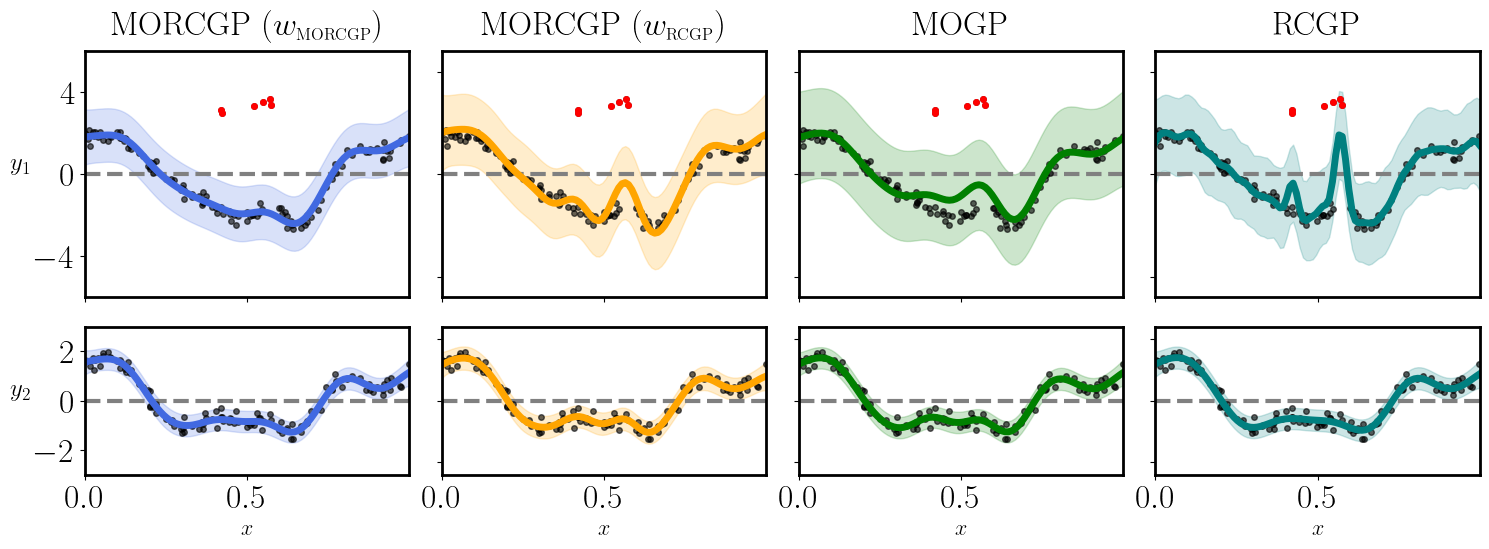

In [6]:
import matplotlib.pyplot as plt

models = [
    {"mu": mu_morcgp, "std": std_morcgp, "label": r"MORCGP ($w_{\scriptscriptstyle\textrm{MORCGP}}$)", "color": "royalblue"},
    {"mu": mu_pm, "std": std_pm, "label": r"MORCGP ($w_{\scriptscriptstyle\textrm{RCGP}}$)", "color": "orange"},
    {"mu": mu_mogp, "std": std_mogp, "label": "MOGP", "color": "green"},
    {"mu": mu_rcgp, "std": std_rcgp, "label": "RCGP", "color": "teal"},
]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 5.5), gridspec_kw={'height_ratios': [1, 0.6]})

def plot_model(ax, i, mu, std, color, label):
    ax.axhline(0, color='grey', linestyle='--', linewidth=3)  # Add y=0 line
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, markersize=4)
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', markersize=4, label='Outliers')
    ax.plot(x_test.flatten(), mu[:, i], '-', color=color, label=label)
    ax.fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color=color, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5])
    if i == 0:
        ax.set_ylim([-6, 6])
    else:
        ax.set_ylim([-3, 3])

for col, model in enumerate(models):
    for row in range(2):
        ax = axes[row, col]
        plot_model(ax, row, model["mu"], model["std"], model["color"], model["label"])

for row in range(2):
    for col in range(4):
        ax = axes[row, col]
        if col > 0:
            ax.set_yticklabels([])
        if row == 0:
            ax.set_xticklabels([])
        else:
            ax.xaxis.set_tick_params(labelbottom=True)
        for spine in ax.spines.values():
            spine.set_linewidth(2)

axes[0, 0].set_ylabel('$y_1$', fontsize=18, labelpad=10, rotation=0)
axes[1, 0].set_ylabel('$y_2$', fontsize=18, labelpad=10, rotation=0)

axes[0, 0].set_yticks([-4, 0, 4])
axes[1, 0].set_yticks([-2, 0, 2])

for col in range(4):
    axes[1, col].set_xlabel(r'$x$', fontsize=16)

for col, model in enumerate(models):
    axes[0, col].set_title(model["label"], fontsize=24, pad=12)

plt.subplots_adjust(wspace=0.1, hspace=0.15)
plt.show()

# fig.savefig("./results/synthetic_MOGP_MORCGP.pdf", format='pdf', bbox_inches='tight')

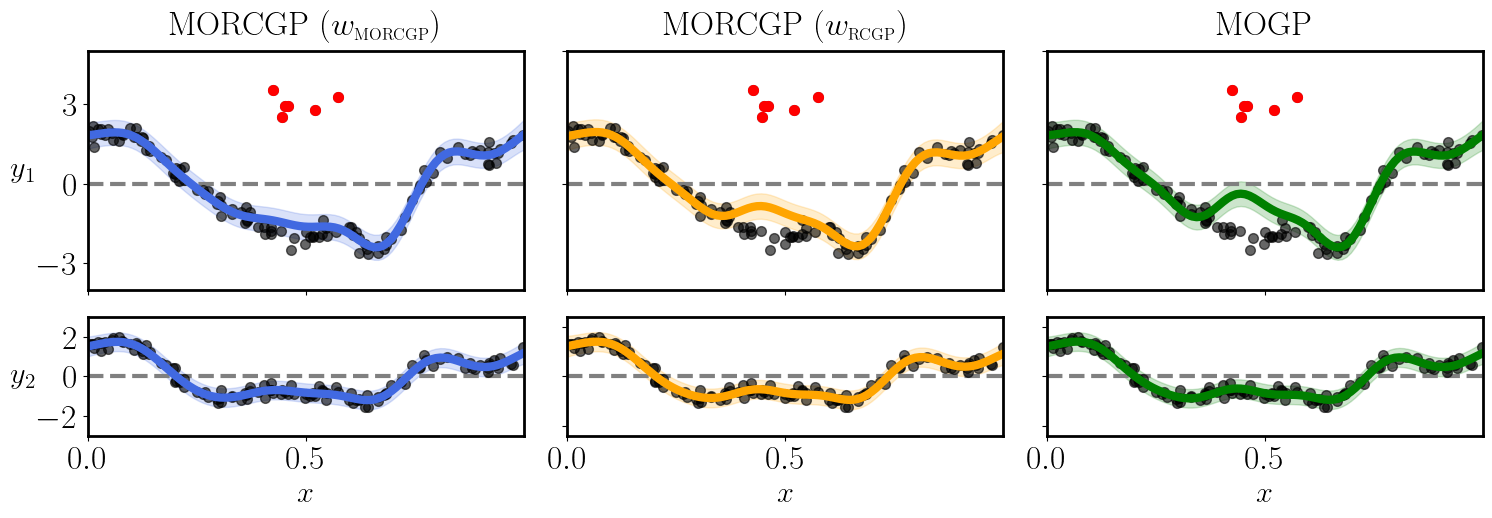

In [ ]:
import matplotlib.pyplot as plt

models = [
    {"mu": mu_morcgp, "std": std_morcgp, "label": r"MORCGP ($w_{\scriptscriptstyle\textrm{MORCGP}}$)", "color": "royalblue"},
    {"mu": mu_pm, "std": std_pm, "label": r"MORCGP ($w_{\scriptscriptstyle\textrm{RCGP}}$)", "color": "orange"},
    {"mu": mu_mogp, "std": std_mogp, "label": "MOGP", "color": "green"},
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 5), gridspec_kw={'height_ratios': [1, 0.5]})

def plot_model(ax, i, mu, std, color, label):
    ax.axhline(0, color='grey', linestyle='--', linewidth=3)  # Add y=0 line
    ax.plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6)
    if i == 0:
        ax.plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outliers')
    ax.plot(x_test.flatten(), mu[:, i], '-', color=color, label=label)
    ax.fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color=color, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5])
    if i == 0:
        ax.set_ylim([-4, 5])
    else:
        ax.set_ylim([-3, 3])

for col, model in enumerate(models):
    for row in range(2):
        ax = axes[row, col]
        plot_model(ax, row, model["mu"], model["std"], model["color"], model["label"])

for row in range(2):
    for col in range(3):
        ax = axes[row, col]
        if col > 0:
            ax.set_yticklabels([])
        if row == 0:
            ax.set_xticklabels([])
        else:
            ax.xaxis.set_tick_params(labelbottom=True)
        for spine in ax.spines.values():
            spine.set_linewidth(2)

axes[0, 0].set_ylabel('$y_1$', fontsize=22, labelpad=18, rotation=0)
axes[1, 0].set_ylabel('$y_2$', fontsize=22, labelpad=18, rotation=0)

axes[0, 0].yaxis.set_label_coords(-0.15, 0.45)
axes[1, 0].yaxis.set_label_coords(-0.15, 0.4)

axes[0, 0].set_yticks([-3, 0, 3])
axes[1, 0].set_yticks([-2, 0, 2])

for col in range(3):
    axes[1, col].set_xlabel(r'$x$', fontsize=22)

for col, model in enumerate(models):
    axes[0, col].set_title(model["label"], fontsize=24, pad=12)

plt.subplots_adjust(wspace=0.1, hspace=0.15)
plt.show()

# fig.savefig("./results/synthetic_MORCGPs_MOGP.pdf", format='pdf', bbox_inches='tight')